<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/problem_sets/solutions/Problem_Set_Three_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title **Imports** { display-mode: "form" }
%%capture 
!pip install jaxopt 

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
from jaxopt import Bisection
import jaxopt 
from functools import partial 
import matplotlib.pyplot as plt 

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### **Prelude**

There is very little that is conceptually new in this problem set. The aim instead is to help you get more comfortable writing math on the computer. By working through the model on your own, you'll develop a better understanding of how the components of the model fit together. Note all parts that expect some kind of input on your end are colored in  <font size="4" color="orange"> orange </font>.

# **Introduction**
Consider the following consumer problem:
\begin{align*}
\underset{l, c}{\textrm{argmax}} \ U_{\alpha}(l, c) \quad \textrm{s.t.} \ c < (24-l)w, \quad l \in [0, 24]
\end{align*}

As you can see, we're modeling the consumer as maximizing a **parameterized** unitility function where the consumer chooses some amount of leisure, l and consumption, c. Additionally, w denotes hourly wage.



# **Part 1**
To begin, <font size="4" color="orange"> write the following functions in the block below</font> :

\begin{align*}
&\textrm{Utility Function}: \quad (A, z, l, c) \longmapsto Al^{z}c^{1-z} \\ 
&\textrm{Max Consumption Function}: \quad (w, l) \longmapsto (24-l)w
\end{align*}

Note, $(A, z)$ parameterize the utility function 

In [4]:
def utility_fn(A, z, l, c): 
  """The utility function: The first two arguments 
  parameterize the utility function"""
  return A*l**z * c **(1-z)

def consumption_fn(w, l):
  """The consumption function, given 
  the wage and amount of leisure returns
  the amout of consumption"""
  return (24-l)*w

A = 2. 
z = 0.5 

If you wrote these function correctly, running the following code cell should plot the graph of the maximum consumption with respect to leisure

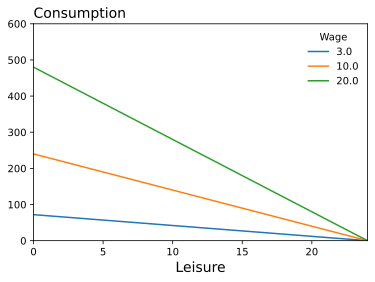

In [5]:
#@title **Plot Maximum Consumption** { display-mode: "form" }
def plot_consumption(consumption_fn, ws):
  ls = jnp.linspace(0., 24., 100)
  for w in ws:
    cs = jax.vmap(partial(consumption_fn, w))(ls)
    plt.plot(ls, cs, label=w)
  plt.title('Consumption', loc='left', size=14)
  plt.xlabel('Leisure', size=14)
  plt.legend(frameon=False, title='Wage')
  plt.xlim(0,24)
  plt.ylim(0, 600)
  plt.show()

plot_consumption(consumption_fn, [3., 10., 20.])

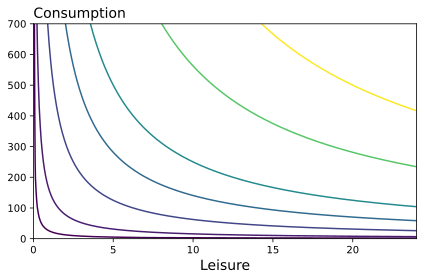

In [6]:
#@title **Graph of Indifference Curves** { display-mode: "form" }

xp=jnp.linspace(0.,24.,200)  # N
yp=jnp.linspace(0.,700.,200)  # M

X, Y = jnp.meshgrid(xp, yp)

def func(x,y):
  return partial(utility_fn, A, z)(x,y)
Z = func(X,Y)
fig = plt.figure(dpi=300, tight_layout=True)
plt.contour(xp,yp,Z,levels=[10, 25, 50, 75, 100, 150, 200]) 
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Leisure', size=14)
plt.show()

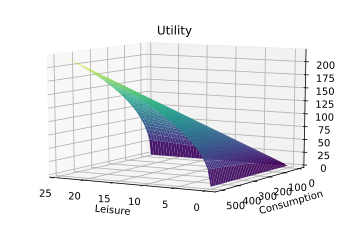

In [7]:
#@title **3D - Graph of Utility Function** { display-mode: "form" }
scale = 2.
alpha=0.5
leisure_end = 24.
consumption_end = 500.


xp=jnp.linspace(0., leisure_end,50)  # N
yp=jnp.linspace(0., consumption_end,50)  # M
X, Y = jnp.meshgrid(xp, yp)

def func(x,y):
  return partial(utility_fn, scale, alpha)(x,y)
Z = func(X,Y)


fig = plt.figure(dpi=300)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Leisure')
ax.set_ylabel('Consumption')
ax.set_title('Utility')
ax.set_title('Utility')
ax.view_init(10, 120)
plt.show()

# **Part 2**
<font size="4" color="orange"> Using the functions that we defined above, please re-write the consumer problem with leisure as the only choice variable</font>

In [8]:
def objective_fn(consumption_fn, A, z, w, l):
  c = consumption_fn(w, l)
  return utility_fn(A, z, l, c)

If you did the step above correctly, the following block will produce the graph of the objective function. Play around with the value of $z$ (i.e. change the values of $z$ and see how the graph changes. What is your sense for how the optimal amount of leisure varies with $z$

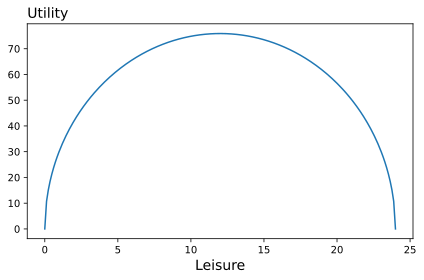

In [11]:
#@title **Utility Function** { display-mode: "form" }
def plot_single_objective(consumption_fn, A, z, w):
  ls = jnp.linspace(0, 24., 200)
  us = jax.vmap(partial(objective_fn, consumption_fn, A, z, w))(ls)
  fig = plt.figure(dpi=300, tight_layout=True)
  plt.plot(ls, us)
  plt.title('Utility', loc='left', size=14)
  plt.xlabel('Leisure', size=14)
  plt.show()

plot_single_objective(consumption_fn, A, z, 10.)

# **Part 3**

<font size="4" color="orange"> With the solver defined for you, please construct the `optimal_bundle` function in the block below </font>

In [12]:
#@title <font size="4" color="purple"> Solver </font> { display-mode: "form" }
def solver(consumption_fn, A, z, w):
  solver = Bisection(optimality_fun=jax.grad(partial(objective_fn, consumption_fn, A, z, w)), lower=0.1, upper=23.9)
  return solver.run().params

In [13]:
def optimal_bundle(consumption_fn, A, z, w):
  optimal_leisure = solver(consumption_fn, A, z, w)
  optimal_consumption = consumption_fn(w, optimal_leisure)
  return optimal_leisure, optimal_consumption

If you have defined the function correctly, the following line of code should plot for you the optimal leisure as a function of the wage. <font size="4" color="orange"> What do you notice is surprising about these graphs? </font>

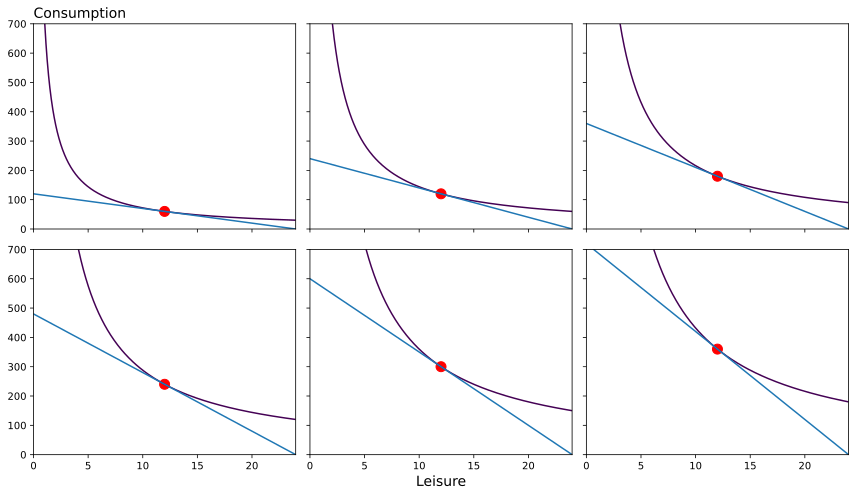

In [15]:
#@title Optimal Bundles { display-mode: "form" }
def plot_optimal_bundles(consumption_fn, A, z, ws):
  fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, dpi=300, tight_layout=True, figsize=(12,7))
  for i, j in enumerate(ws):
    row = i//3 
    col = i % 3
    l_opt, c_opt = optimal_bundle(consumption_fn, A, z, j)
    u_opt = utility_fn(A, z, l_opt, c_opt)


    xp=jnp.linspace(0.,24.,200)  # N
    yp=jnp.linspace(0.,700.,200)  # M

    X, Y = jnp.meshgrid(xp, yp)

    def func(x,y):
      return partial(utility_fn, scale, alpha)(x,y)

    Z = func(X,Y)
    ax[row, col].contour(xp,yp,Z,levels=[u_opt.item()]) 
    if row == 0 and col == 0:
      ax[row, col].set_title('Consumption', loc='left', size=14)
    if row == 1 and col == 1:
      ax[row,col].set_xlabel('Leisure', size=14)
    ls = jnp.linspace(0, 24, 100)
    cs = jax.vmap(partial(consumption_fn, j))(ls)
    ax[row, col].plot(ls,cs, label='budget line')
    ax[row, col].scatter(l_opt, c_opt, color='red', s=100, label='Optimal Bundle')
    plt.xlim(0,24)
    plt.ylim(0, 700)
  plt.show()

ws = [5., 10., 15., 20., 25., 30.]
plot_optimal_bundles(consumption_fn, A, z, ws)

Now that we can solve for the optimal bundle, we can express the optimal amount of leisure as a gunction of wages


\begin{align*}
\textrm{optimal_leisure}^*(w):= \underset{l \in [0,24]}{\textrm{argmax}} \ U_{\alpha}(l, c^*(w, l))
\end{align*}

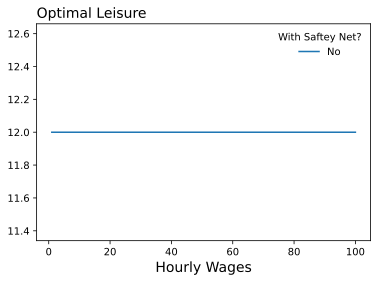

In [16]:
#@title **Optimal Leisure** { display-mode: "form" }
wages = jnp.linspace(1., 100., 40)
leisure = []
for w in wages:
  leisure.append(optimal_bundle(consumption_fn, A, z, w)[0])

plt.plot(wages, leisure, label='No') 
plt.title('Optimal Leisure', loc='left', size=14)
plt.xlabel('Hourly Wages', size=14)
plt.legend(frameon=False, title='With Saftey Net?')
plt.show()

# **Part 4**

Let's now consider how we might model the effect of some type of social saftey net. For instance, let's assume that an individual receives some amount of additional consumption regardless of whether they work. We can express this as a function of leisure as follows:

\begin{align*}
\textrm{saftey_net}(l) = 50. 
\end{align*}

By expressing this as a function of leisure, it will be straightforward to change the code to incorporate policies like the Earned Income Tax Credit where the amount of governmental support is a function of the amount of hours worked. 

<font size="4" color="orange"> Please write down the `safety_net` function and the `consumption_saftey_fn` which should make use of the previously defined `consumption_fn`</font>




In [17]:
def saftey_net(l):
  return 50.

def consumption_saftey_fn(saftey_net, w, l):
  return saftey_net(l) + consumption_fn(w, l)

If everything works, you should see graphs representing the optimal bundle for a couple different wages plotted below. <font size="4" color="orange"> How do these plots differ from the case about with no social saftey net? </font>

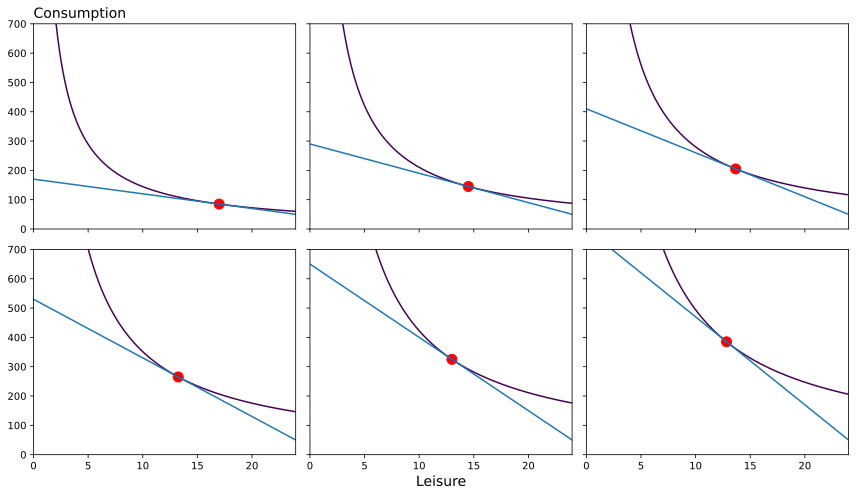

In [18]:
ws = [5., 10., 15., 20., 25., 30.]
plot_optimal_bundles(partial(consumption_saftey_fn, saftey_net), A, z, ws)

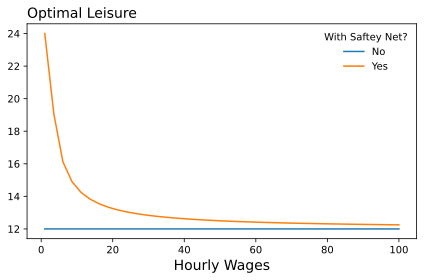

In [20]:
#@title Compare Optimal Leisure Functions { display-mode: "form" }
leisure_sn = []
for w in wages:
  try: 
    opt_leisure = optimal_bundle(partial(consumption_saftey_fn, saftey_net), A, z, w)[0]
  except ValueError: 
    opt_leisure = 24.

  leisure_sn.append(opt_leisure)
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(wages, leisure, label='No') 
plt.plot(wages, leisure_sn, label='Yes') 
plt.title('Optimal Leisure', loc='left', size=14)
plt.xlabel('Hourly Wages', size=14)
plt.legend(frameon=False, title='With Saftey Net?')
plt.show()

### **Part 5**
If you call the optimal bundle function with a wage of `1`, the solver will return an error.  <font size="4" color="orange"> Can you think figure out why this happens? </font>

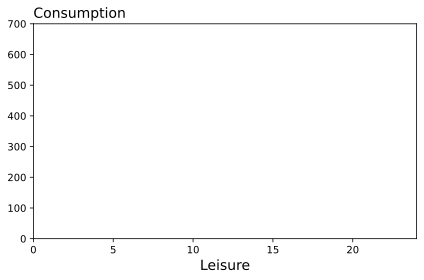

In [21]:
#@title Visual Hint { display-mode: "code" }
try:
  l_opt, c_opt = optimal_bundle(partial(consumption_saftey_fn, saftey_net), 2., 0.5, 1.)
except ValueError:
  l_opt =24.
  c_opt = partial(consumption_saftey_fn, saftey_net)(1., 24.)
u_opt = utility_fn(2., .5, l_opt, c_opt)
xp=jnp.linspace(0.,24.,200)  # N
yp=jnp.linspace(0.,700.,200)  # M
X, Y = jnp.meshgrid(xp, yp)

def func(x,y):
  return partial(utility_fn, scale, alpha)(x,y)

Z = func(X,Y)
#plt.contour(xp,yp,Z,levels=[u_opt]) 
ls = jnp.linspace(0, 24, 100)
cs = jax.vmap(partial(partial(consumption_saftey_fn, saftey_net), 1.))(ls)
fig = plt.figure(dpi=300, tight_layout=True)
#plt.plot(ls,cs, label='budget line')
#plt.scatter(l_opt, c_opt, color='red', s=100, label='Optimal Bundle')
plt.xlabel('Leisure', size=14)
plt.title('Consumption', size=14, loc='left')
plt.xlim(0,24)
plt.ylim(0, 700)
plt.show()